In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


import visualkeras
from PIL import ImageFont

import shap

import os
import numpy as np
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import random
import matplotlib.pyplot as plt




## Data Loading and Initialisation




In [5]:
root_path = r"C:\Users\Jarushen\Desktop\Masters Thesis\Images\Fynbos_Dataset_B"  # FLORA Dataset B

In [6]:
top5_acc = TopKCategoricalAccuracy(k=5, name='top5_acc')
top10_acc = TopKCategoricalAccuracy(k=10, name='top10_acc')

In [7]:
# Initialize an image data generator with some data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Load images from directory
train_generator = datagen.flow_from_directory(
    root_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    root_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)




Found 706 images belonging to 23 classes.
Found 163 images belonging to 23 classes.


## CNN Architecture

In [8]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])


## Model Compile

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', top5_acc, top10_acc])

## Train Model

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

Epoch 1/50
23/23 [==============================] - 191s 8s/step - loss: 3.1168 - accuracy: 0.0652 - top5_acc: 0.2861 - top10_acc: 0.5255 - val_loss: 3.0067 - val_accuracy: 0.0675 - val_top5_acc: 0.3620 - val_top10_acc: 0.6074
Epoch 2/50
23/23 [==============================] - 182s 8s/step - loss: 3.0025 - accuracy: 0.0878 - top5_acc: 0.3853 - top10_acc: 0.6459 - val_loss: 2.9601 - val_accuracy: 0.1227 - val_top5_acc: 0.4172 - val_top10_acc: 0.7239
Epoch 3/50
23/23 [==============================] - 172s 8s/step - loss: 2.9079 - accuracy: 0.1317 - top5_acc: 0.4320 - top10_acc: 0.7096 - val_loss: 2.8357 - val_accuracy: 0.1718 - val_top5_acc: 0.4417 - val_top10_acc: 0.7914
Epoch 4/50
23/23 [==============================] - 178s 8s/step - loss: 2.8152 - accuracy: 0.1374 - top5_acc: 0.4688 - top10_acc: 0.7493 - val_loss: 2.7670 - val_accuracy: 0.1718 - val_top5_acc: 0.4908 - val_top10_acc: 0.7607
Epoch 5/50
23/23 [==============================] - 184s 8s/step - loss: 2.7054 - accuracy: 

array([ 0,  0,  0,  1,  2,  3,  4,  5,  6,  6,  7,  8,  8,  9,  9, 10, 11,
       11, 12, 12, 13, 15, 15, 16, 16, 16, 16, 16, 17, 17, 18, 19, 19, 19,
       20, 20, 20, 20, 20, 21, 21, 22, 22, 22, 22, 23, 23, 24, 24, 25, 25,
       25, 26, 26, 26, 27, 27, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 31,
       31, 31, 32, 33, 34, 34, 34, 34])

In [10]:
val_loss, val_accuracy, *_ = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")

6/6 [==============================] - 227s 38s/step - loss: 2.0134 - accuracy: 0.3742 - top5_acc: 0.7423 - top10_acc: 0.9448
Validation accuracy: 37.42%


In [51]:
model.save(r"C:\Users\Jarushen\Desktop\Masters Thesis\Code\Models\Baseline_B")

FailedPreconditionError: C:\Users\Jarushen\Desktop\Masters Thesis\Code\Models\Baseline_1 is not a directory

In [10]:
# Path to the saved model
model_path = r"C:\Users\Jarushen\Desktop\Masters Thesis\Code\Models\Baseline_B"

# Load the model
model = tf.keras.models.load_model(model_path)

## Classification Report

In [21]:
validation_generator.reset()  # Resetting generator to avoid shuffling
predictions = model.predict(validation_generator)

6/6 [==============================] - 76s 13s/step


In [22]:
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

6/6 [==============================] - 73s 12s/step


In [24]:
# Generate target_names based on the classes present in the validation generator
target_names = [k for k, v in sorted(validation_generator.class_indices.items(), key=lambda item: item[1])]

# Generate the classification report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, labels=np.arange(len(target_names))))


Classification Report
                         precision    recall  f1-score   support

       Aloe arborescens       0.50      0.33      0.40         6
       Aristea capitata       0.25      0.25      0.25         4
 Baloskion tetraphyllum       0.50      0.25      0.33         4
     Carpobrotus edulis       0.20      0.25      0.22         4
   Cotyledon orbiculata       0.25      0.11      0.15         9
       Curio talinoides       0.67      0.75      0.71         8
      Erica arborescens       0.33      1.00      0.50         5
          Erica cinerea       1.00      0.43      0.60         7
         Erica discolor       0.46      1.00      0.63         6
  Helichrysum petiolare       0.75      0.27      0.40        11
 Leucadendron argenteum       0.53      1.00      0.69        10
 Leucadendron laureolum       0.50      0.14      0.22         7
  Leucadendron salignum       0.78      1.00      0.88         7
       Melianthus major       0.50      0.20      0.29        10
  

ModuleNotFoundError: No module named 'shap'

## Confusion Matrix

In [25]:
cm = confusion_matrix(validation_generator.classes, y_pred)

In [24]:
# Define a function to print the confusion matrix neatly
def print_confusion_matrix(confusion_matrix, class_names):
    pretty_print = "\t" + "\t".join(class_names) + "\n"
    for i, row in enumerate(confusion_matrix):
        pretty_print += class_names[i] + "\t" + "\t".join(str(cell) for cell in row) + "\n"
    print(pretty_print)

# Assuming 'target_names' contains the list of class names in the order they are encoded
print_confusion_matrix(cm, target_names)


	Aloe arborescens	Aristea capitata	Baloskion tetraphyllum	Carpobrotus edulis	Cotyledon orbiculata	Curio talinoides	Erica arborescens	Erica cinerea	Erica discolor	Helichrysum petiolare	Leucadendron argenteum	Leucadendron laureolum	Leucadendron salignum	Melianthus major	Mutisia orbignyana	Oscularia deltoides	Osyris lanceolata	Ozothamnus leptophyllus	Pelargonium crispum	Protea cynaroides	Protea neriifolia	Protea repens	Strelitzia reginae
Aloe arborescens	3	0	0	0	0	0	0	0	0	0	0	0	0	2	0	0	1	0	0	0	0	0	0
Aristea capitata	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	0	0	0	1	1	0	0
Baloskion tetraphyllum	0	0	2	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0
Carpobrotus edulis	0	0	0	3	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0
Cotyledon orbiculata	2	0	0	1	2	0	0	0	1	0	0	0	0	1	0	0	0	0	0	1	0	0	1
Curio talinoides	0	0	0	0	0	2	0	0	0	2	0	0	0	3	0	1	0	0	0	0	0	0	0
Erica arborescens	0	0	1	0	0	0	3	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0
Erica cinerea	0	0	0	0	0	0	0	3	1	0	0	0	0	1	0	1	0	0	0	0	1	0	0
Erica discolor	2	0	0	0	0	0	0	0	3	0	0	0	1	0	0	0	

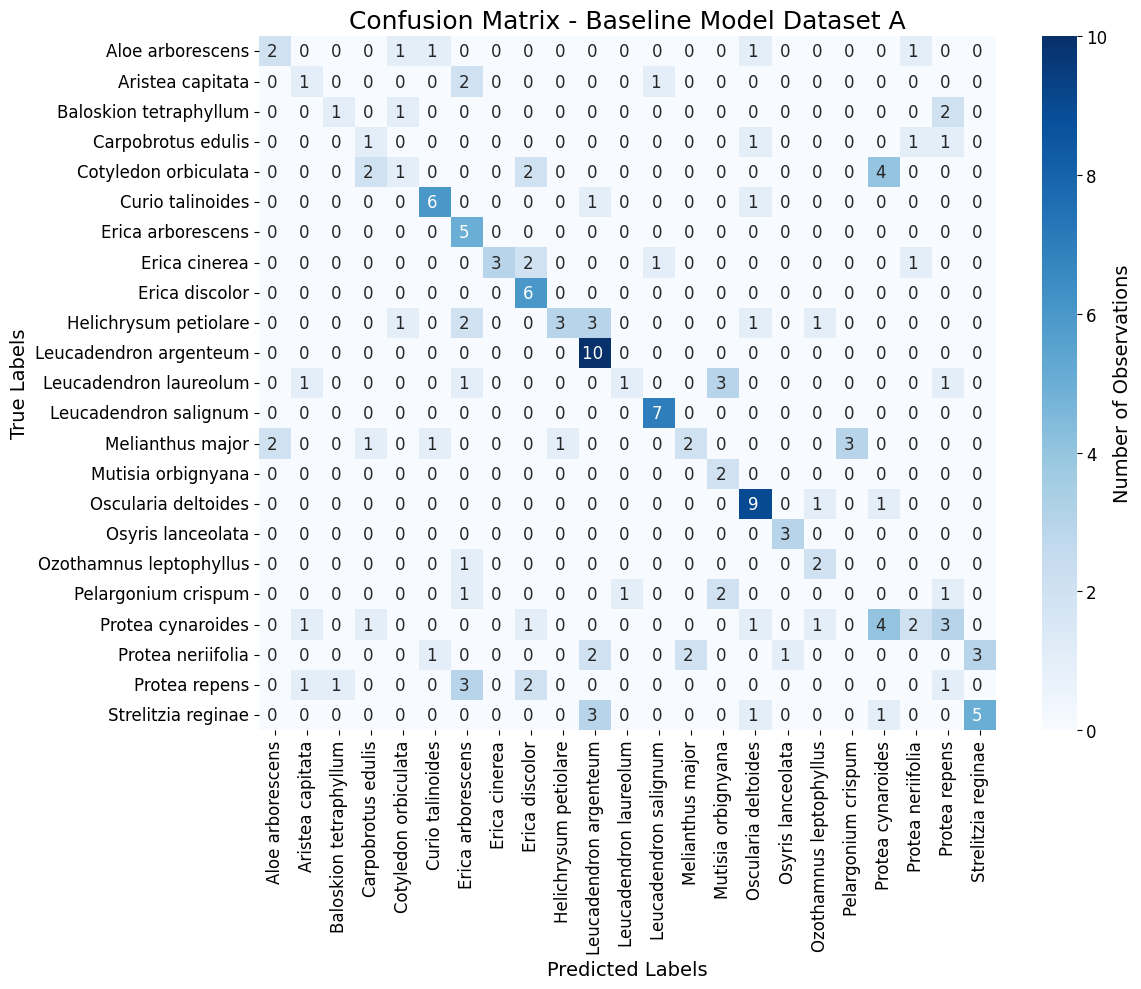

In [30]:
import seaborn as sns

plt.figure(figsize=(12, 10))  # Increased figure size for better readability

# Creating the heatmap
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                 xticklabels=target_names, yticklabels=target_names)

# Rotate the x-axis labels
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for consistency

# Setting labels and title with increased font size for readability
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix - Baseline Model Dataset A', fontsize=18)

# Increasing the font size of the annotations
for t in ax.texts:
    t.set_text(t.get_text() + " ")  # Adding space for better visibility
    t.set_size(12)  # Increase the annotation text size if needed

ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size

# Adjust color bar label size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # Adjust the color bar tick label size
cbar.set_label('Number of Observations', fontsize=14)

plt.tight_layout()  # Adjusts the plot to fit into the figure area.

# Save the figure with a higher resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\confusion_matrix_Baseline_B.png",
            format='png', dpi=400, bbox_inches='tight')  # Increased DPI for higher resolution

# Show the plot
plt.show()



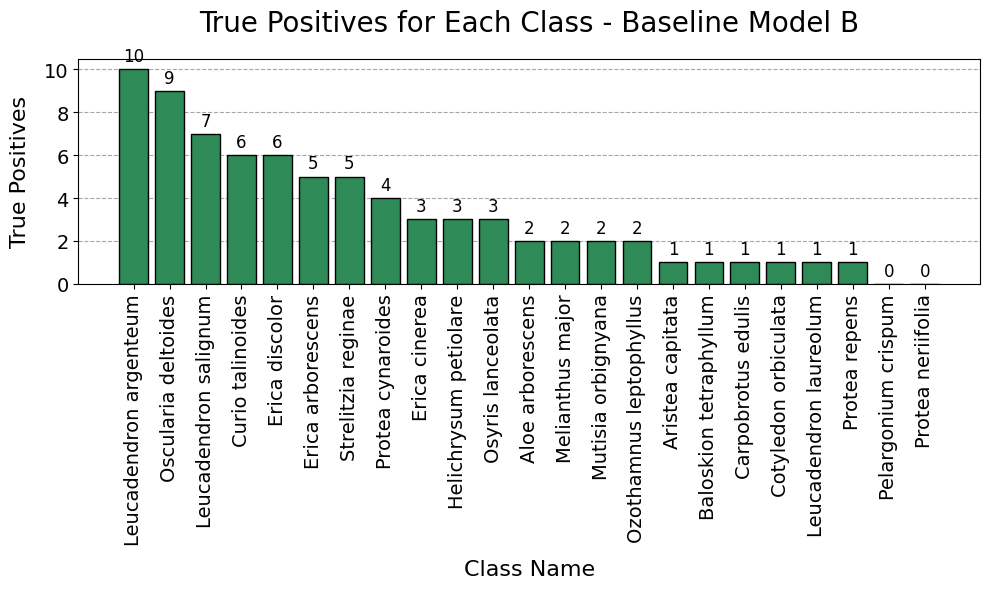

In [28]:
import matplotlib.pyplot as plt
import numpy as np



# Extract true positives from the confusion matrix
true_positives = np.diag(cm)

# Pair each class name with its corresponding true positive count and sort
sorted_pairs = sorted(zip(target_names, true_positives), key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs
sorted_target_names, sorted_true_positives = zip(*sorted_pairs)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Create bar plot with sorted data
bars = ax.bar(sorted_target_names, sorted_true_positives, color='seagreen', edgecolor='black')

# Add labels and title
ax.set_xlabel('Class Name', fontsize=16, labelpad=10)
ax.set_ylabel('True Positives', fontsize=16, labelpad=10)
ax.set_title('True Positives for Each Class - Baseline Model B', fontsize=20, pad=20)

plt.xticks(rotation=90, fontsize=14)  # Labels are now horizontal
plt.yticks(fontsize=14)

# Add data labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

# Add grid lines behind the bars for better readability of the y-values
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\Baseline_B_true_positives_bar_graph.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Accuracy

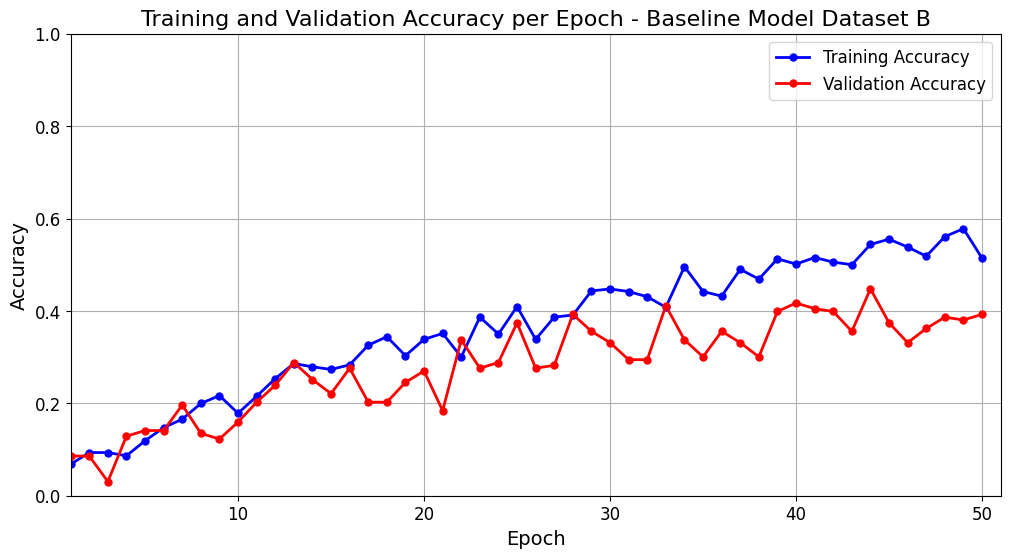

In [33]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model.fit() method
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Increase line thickness and marker size
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=5)

# Title and labels with increased font size
plt.title('Training and Validation Accuracy per Epoch - Baseline Model Dataset B', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Set fixed axes limits
plt.ylim([0, 1])
plt.xlim([1, 51])

# Enhanced tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Increase legend font size
plt.legend(fontsize=12)

# Save the figure in high resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\Epoch_B.png", format='png', dpi=300)

plt.show()


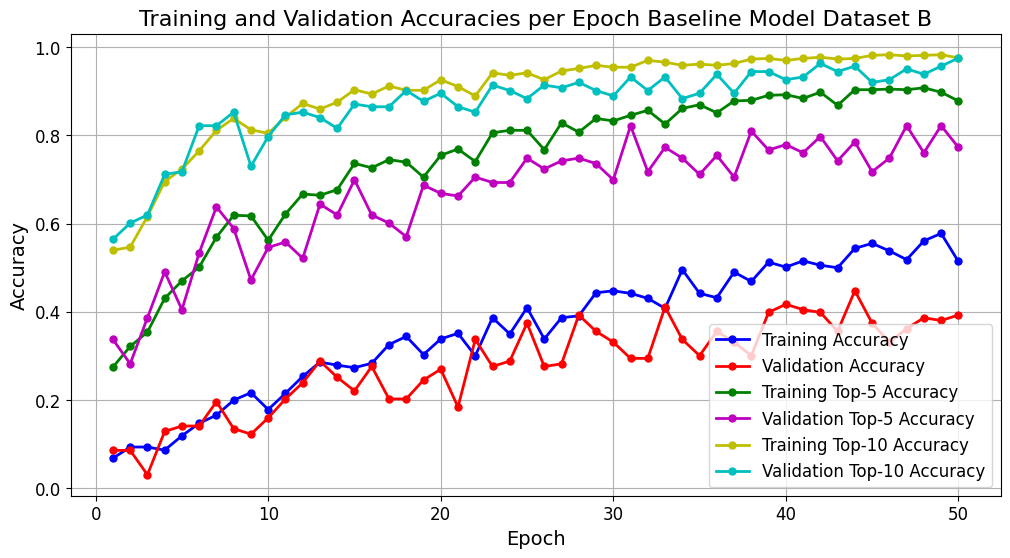

In [34]:
import matplotlib.pyplot as plt

# Assuming 'history' contains 'accuracy', 'val_accuracy', 'top5_accuracy', 'val_top5_accuracy', 'top10_accuracy', 'val_top10_accuracy'
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Standard accuracy with increased line thickness and marker size
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=5)

# Top-5 accuracy with increased line thickness and marker size
plt.plot(epochs, history.history['top5_acc'], 'go-', label='Training Top-5 Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_top5_acc'], 'mo-', label='Validation Top-5 Accuracy', linewidth=2, markersize=5)

# Top-10 accuracy with increased line thickness and marker size
plt.plot(epochs, history.history['top10_acc'], 'yo-', label='Training Top-10 Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_top10_acc'], 'co-', label='Validation Top-10 Accuracy', linewidth=2, markersize=5)

# Title and labels with increased font size
plt.title('Training and Validation Accuracies per Epoch Baseline Model Dataset B', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Enhanced tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Increase legend font size
plt.legend(fontsize=12)

# Save the figure in high resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\t5t10_B_Baseline.png", format='png', dpi=300)

# Show the plot
plt.show()

## Loss

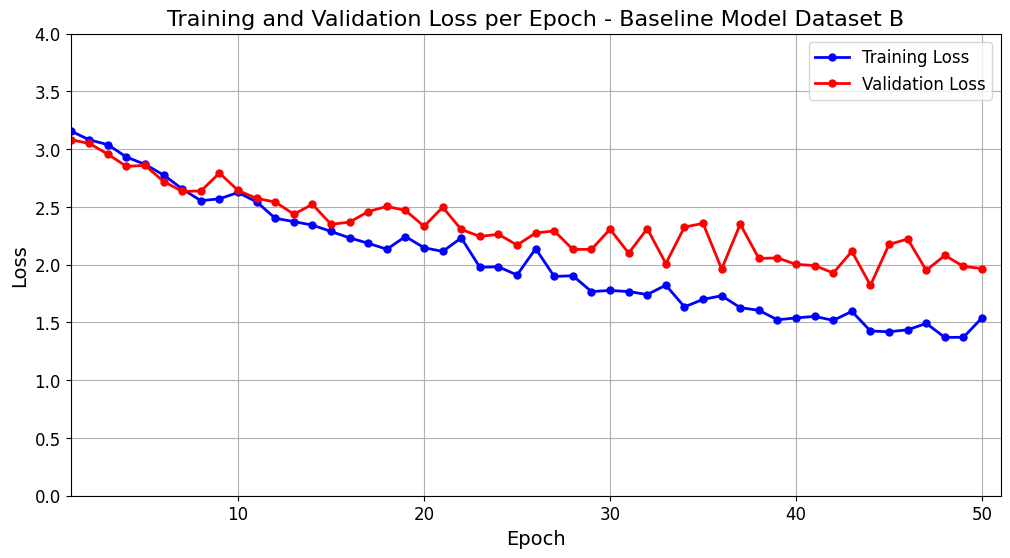

In [35]:
import matplotlib.pyplot as plt

# Replace 'loss' and 'val_loss' with the actual keys if they are different
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 6))

# Plot training and validation loss with increased line thickness and marker size
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=5)

# Title and labels with increased font size
plt.title('Training and Validation Loss per Epoch - Baseline Model Dataset B', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Enhanced tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Increase legend font size
plt.legend(fontsize=12)

# Set fixed axes limits
plt.ylim([0, 4])
plt.xlim([1, 51])

# Save the plot in high resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\epoch_B_Loss.png", format='png', dpi=300)

# Show the plot
plt.show()


## Layer Visualisation

In [85]:

# Assuming 'model' is your Sequential model

# If you want to use a custom font, specify the path to a .ttf file (optional)
# For example, using Arial font in Windows. Replace 'arial.ttf' with the full path to the font file if needed
# font = ImageFont.truetype("arial.ttf", 12)

# Specify custom colors for different layers (optional)
color_map = {
    'Conv2D': 'skyblue', 
    'MaxPooling2D': 'tomato', 
    'Dense': 'orange', 
    'Dropout': 'lightgreen', 
    'Flatten': 'teal'
    # Add more layers and colors as needed
}

# Create a layered view with custom settings
layered_view = visualkeras.layered_view(model, legend=True, color_map=color_map, to_file='model_visualization.png') 
# Remove 'to_file' parameter if you don't want to save it yet

# Save the visualization as a high-quality image
layered_view.save(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Methodology\model_visualization_labeled.png", dpi=300) # dpi can be adjusted for higher resolution

AttributeError: 'ImageFont' object has no attribute 'getsize'

In [92]:
plot_model(model, to_file=r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Methodology\visualisation", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## SHAP Analysis

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Function to load and preprocess the image
def load_preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image
    return img_array


# Directory of the class you want to analyze
class_dir = r"C:\Users\Jarushen\Desktop\Masters Thesis\Images\Fynbos_Dataset_A\Agathosma serpyllacea"  # Replace with your class directory

# Directory to save the SHAP plots
save_dir = r"C:\Users\Jarushen\Desktop\Masters Thesis\Images\SHAP_Results\Baseline B"  # Replace with your desired save directory
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, np.zeros((1, 150, 150, 3)))

# Iterate through each image in the specified class directory
for img_file in os.listdir(class_dir):
    if 'IMG' in img_file:
        img_path = os.path.join(class_dir, img_file)
        preprocessed_image = load_preprocess_image(img_path, (150, 150))

        # Predict the class of the image
        predictions = model.predict(preprocessed_image)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Compute SHAP values for the predicted class
        shap_values = explainer.shap_values(preprocessed_image)
        shap_values_for_predicted_class = shap_values[predicted_class][0]

        # Plot SHAP values
        plt.figure()
        shap.image_plot(shap_values_for_predicted_class, preprocessed_image[0],show=False)

        # Save the plot in the specified directory
        plt.savefig(os.path.join(save_dir, f'shap_output_{img_file}_agathosma_serpyllacea.png'))
        plt.close()  # Close the plot to free memory

print("All SHAP analysis plots saved.")



  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.24.4 which is incompatible.


In [110]:
!pip install numpy==1.24.3

     ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
     --------------------------------------- 0.0/14.9 MB 262.6 kB/s eta 0:00:57
     --------------------------------------- 0.1/14.9 MB 409.6 kB/s eta 0:00:37
     - -------------------------------------- 0.6/14.9 MB 3.1 MB/s eta 0:00:05
     -------- ------------------------------- 3.1/14.9 MB 13.3 MB/s eta 0:00:01
     ----------- ---------------------------- 4.2/14.9 MB 15.7 MB/s eta 0:00:01
     ----------- ---------------------------- 4.2/14.9 MB 15.7 MB/s eta 0:00:01
     ----------- ---------------------------- 4.2/14.9 MB 15.7 MB/s eta 0:00:01
     ----------- ---------------------------- 4.2/14.9 MB 15.7 MB/s eta 0:00:01
     ----------- ---------------------------- 4.2/14.9 MB 15.7 MB/s eta 0:00:01
     --------------- ------------------------ 5.9/14.9 MB 11.2 MB/s eta 0:00:01
     ------------------- -------------------- 7.3/14.9 MB

NameError: name 'sample_data' is not defined

Name: shap
Version: 0.41.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: http://github.com/slundberg/shap
Author: Scott Lundberg
Author-email: slund1@cs.washington.edu
License: MIT
Location: c:\programdata\anaconda3\envs\flora\lib\site-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm
Required-by: 


In [3]:
model_path = r"C:\Users\Jarushen\Desktop\Masters Thesis\Code\Models\Baseline_B"

# Load the model
model = tf.keras.models.load_model(model_path)

TypeError: __init__() takes from 2 to 4 positional arguments but 5 were given

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Function to load and preprocess the image
def load_preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image
    return img_array


# Directory of the class you want to analyze
class_dir = r"C:\Users\Jarushen\Desktop\Masters Thesis\Images\Fynbos_Dataset_B\Protea neriifolia"  # Replace with your class directory

# Directory to save the SHAP plots
save_dir = r"C:\Users\Jarushen\Desktop\Masters Thesis\Images\SHAP_Results\Baseline B"  # Replace with your desired save directory
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, np.zeros((1, 150, 150, 3)))

# Iterate through each image in the specified class directory
for img_file in os.listdir(class_dir):
    if 'IMG' in img_file:
        img_path = os.path.join(class_dir, img_file)
        preprocessed_image = load_preprocess_image(img_path, (150, 150))

        # Predict the class of the image
        predictions = model.predict(preprocessed_image)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Compute SHAP values for the predicted class
        shap_values = explainer.shap_values(preprocessed_image)
        shap_values_for_predicted_class = shap_values[predicted_class][0]

        # Plot SHAP values
        plt.figure()
        shap.image_plot(shap_values_for_predicted_class, preprocessed_image[0],show=False)

        # Save the plot in the specified directory
        plt.savefig(os.path.join(save_dir, f'shap_output_{img_file}_protea neriifolia.png'))
        plt.close()  # Close the plot to free memory

print("All SHAP analysis plots saved.")



1/1 [==============================] - 0s 40ms/step


KeyboardInterrupt: 

In [ ]:
For Dataset B: Oscularia deltoides, Osyris lanceolata, Leucadendron salignum
For Both Datasets: Aloe arborescens, Aristea capitata

In [18]:
from sklearn.metrics import f1_score

# Evaluate the model on the validation set
val_loss, val_accuracy, val_top5_acc, val_top10_acc = model.evaluate(validation_generator)

# Get predictions and true labels from the validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Calculate F1 score for the validation set
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Prepare the data for the table
data = {
    "Metric": ["Accuracy", "F1 Score", "Loss", "Top 5 Accuracy", "Top 10 Accuracy"],
    "Value": [val_accuracy, f1, val_loss, val_top5_acc, val_top10_acc]
}

# Create DataFrame and display
results_table = pd.DataFrame(data)
print(results_table)

6/6 [==============================] - 96s 16s/step
            Metric     Value
0         Accuracy  0.466258
1         F1 Score  0.419244
2             Loss  1.807953
3   Top 5 Accuracy  0.815951
4  Top 10 Accuracy  0.969325
